In [1]:


# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
import pandas as pd
driver_imgs_list = pd.read_csv("../input/state-farm-distracted-driver-detection/driver_imgs_list.csv")
sample_submission = pd.read_csv("../input/state-farm-distracted-driver-detection/sample_submission.csv")

In [3]:
import warnings
warnings.filterwarnings("ignore")

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from dask.array.image import imread
import cv2
import random
import gc

import keras
from keras.models import Model
from keras.layers import Input, Dropout, Dense,GlobalAveragePooling2D
from keras.utils import to_categorical
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.preprocessing.image import img_to_array,ImageDataGenerator,array_to_img
from keras.applications.xception import preprocess_input, decode_predictions
from keras.applications.xception import Xception

In [4]:
#Submission code
#from PIL import Image
#from keras.models import load_model
#model=load_model('../input/xceptionweight5/xception_weight_v5.hdf5')
#def get_data(image_path):
#    img = Image.open(image_path)
#    img = img.resize((299, 299), Image.ANTIALIAS) # resizes image in-place
#    return np.asarray(img)/255
#
#for i, file in enumerate(sample_submission['img']):
#    image = get_data('../input/state-farm-distracted-driver-detection/imgs/test/' + file)
#    image = np.reshape(image, (1, image.shape[0], image.shape[1], image.shape[2]))
#    result = model.predict(image)
#    sample_submission.iloc[i, 1:] = result[0]
#    print(file+"done"+str(i))
#    
#sample_submission.to_csv('results.csv', index = False)

In [5]:
driver_details = pd.read_csv('../input/state-farm-distracted-driver-detection/driver_imgs_list.csv',na_values='na')
train_image = []

for i in range(10):
    imgs = os.listdir("../input/state-farm-distracted-driver-detection/imgs/train/c"+str(i))
    for j in range(500):
        if j>=len(imgs):
            break
        img_name = "../input/state-farm-distracted-driver-detection/imgs/train/c"+str(i)+"/"+imgs[j]
        img = cv2.imread(img_name)
        img = img[50:,120:-50]
        img = cv2.resize(img,(299,299))
        label = i
        driver = driver_details[driver_details['img'] == imgs[j]]['subject'].values[0]
        train_image.append([img,label,driver])
    print('Finished c',i)

Finished c 0
Finished c 1
Finished c 2
Finished c 3
Finished c 4
Finished c 5
Finished c 6
Finished c 7
Finished c 8
Finished c 9


In [6]:
random.shuffle(train_image)
#driv_selected = ['p045', 'p015', 'p019', 'p032']
#driv_selected = ['p023', 'p033', 'p047', 'p010']
driv_selected = ['p050', 'p042', 'p037', 'p026']

In [7]:
X_train= []
y_train = []
X_test = []
y_test = []

for features,labels,drivers in train_image:
    if drivers in driv_selected:
        X_test.append(features)
        y_test.append(labels)
    
    else:
        X_train.append(features)
        y_train.append(labels)
    
print (len(X_train),len(X_test))
print (len(y_train),len(y_test))

4465 535
4465 535


In [8]:
del train_image
del imgs
del driver_details
gc.collect()

82

In [9]:
X_train = np.array(X_train).reshape(-1,299,299,3)
X_test = np.array(X_test).reshape(-1,299,299,3)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print (X_train.shape)

(4465, 299, 299, 3)


In [10]:
#Save best model
checkpointer = ModelCheckpoint('xception_weight_v5.hdf5', verbose=1, save_best_only=True)
#Stop if loss doesn't decrease for 10 epochs
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

#Image Aug
datagen = ImageDataGenerator(
    height_shift_range=0.3,
    width_shift_range = 0.3,
    zoom_range = 0.3,
    rotation_range=30
        )

data_generator = datagen.flow(X_train, y_train, batch_size = 32)

In [11]:
#Define Xception Model
input_tensor = Input(shape = (299, 299, 3))
base = Xception(include_top=False, pooling='avg')
base_xception = base(input_tensor)

#Add the fully-connected layers 
x = Dense(1024,activation='relu')(base_xception)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(512,activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(64,activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(10, activation='softmax')(x)

xception_pretrained = Model(input_tensor, x)

xception_pretrained.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_4 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
______________________________________________________________

In [12]:
#retrieve model
#xception_pretrained.load_weights("../input/xceptionweight4/xception_weight_v4.hdf5")

Epoch 1/30
139/139 [==============================] - 123s 820ms/step - loss: 3.3130 - accuracy: 0.1245 - val_loss: 2.1609 - val_accuracy: 0.2206

Epoch 00001: val_loss improved from inf to 2.16087, saving model to xception_weight_v5.hdf5
Epoch 2/30
139/139 [==============================] - 116s 829ms/step - loss: 1.9835 - accuracy: 0.3510 - val_loss: 1.0768 - val_accuracy: 0.6841

Epoch 00002: val_loss improved from 2.16087 to 1.07679, saving model to xception_weight_v5.hdf5
Epoch 3/30
139/139 [==============================] - 115s 822ms/step - loss: 1.1776 - accuracy: 0.5983 - val_loss: 0.6591 - val_accuracy: 0.7925

Epoch 00003: val_loss improved from 1.07679 to 0.65907, saving model to xception_weight_v5.hdf5
Epoch 4/30
139/139 [==============================] - 115s 824ms/step - loss: 0.7916 - accuracy: 0.7348 - val_loss: 0.5460 - val_accuracy: 0.8000

Epoch 00004: val_loss improved from 0.65907 to 0.54604, saving model to xception_weight_v5.hdf5
Epoch 5/30
139/139 [============

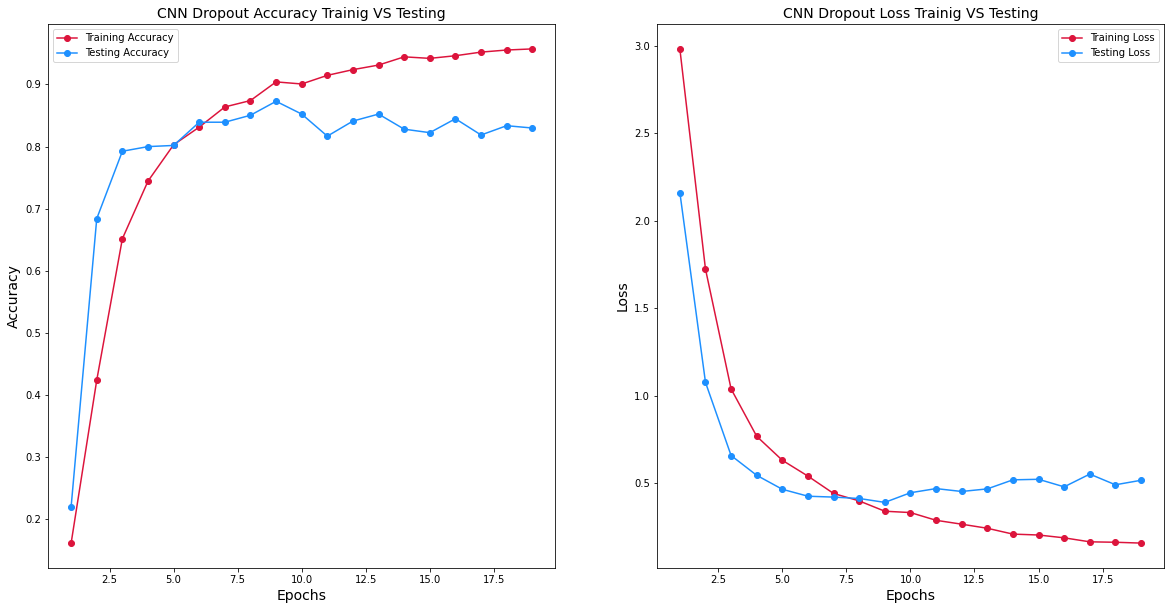

In [13]:
xception_pretrained.compile(loss='categorical_crossentropy',optimizer = optimizers.SGD(lr=0.01),metrics=['accuracy'])
xception_model = xception_pretrained.fit(data_generator,steps_per_epoch = len(X_train) / 32, callbacks = [checkpointer, earlystopper],
                                                            epochs = 30, verbose = 1, validation_data = (X_test, y_test))


fig, axes = plt.subplots(1, 2, figsize = (20, 10))
axes[0].plot(range(1, len(xception_pretrained.history.history['accuracy']) + 1), xception_pretrained.history.history['accuracy'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Accuracy')
axes[0].plot(range(1, len(xception_pretrained.history.history['val_accuracy']) + 1), xception_pretrained.history.history['val_accuracy'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Accuracy')
axes[0].set_xlabel('Epochs', fontsize = 14)
axes[0].set_ylabel('Accuracy',fontsize = 14)
axes[0].set_title('CNN Dropout Accuracy Trainig VS Testing', fontsize = 14)
axes[0].legend(loc = 'best')
axes[1].plot(range(1, len(xception_pretrained.history.history['loss']) + 1), xception_pretrained.history.history['loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Loss')
axes[1].plot(range(1, len(xception_pretrained.history.history['val_loss']) + 1), xception_pretrained.history.history['val_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Loss')
axes[1].set_xlabel('Epochs', fontsize = 14)
axes[1].set_ylabel('Loss',fontsize = 14)
axes[1].set_title('CNN Dropout Loss Trainig VS Testing', fontsize = 14)
axes[1].legend(loc = 'best')

In [14]:
#sample image augmentation
#img = cv2.imread("../input/state-farm-distracted-driver-detection/imgs/train/c0/img_1005.jpg")
#plt.imshow(img)
#plt.show()
#
#x = img_to_array(img)
#x = x.reshape((1,) + x.shape)
#
#datagen_sample = ImageDataGenerator(
#    height_shift_range=0.3,
#    width_shift_range = 0.3,
#    zoom_range = 0.3,
#    rotation_range=30
#        )
#
#g = datagen_sample.flow(x, batch_size=1)
#plt.subplots(figsize=(12,8))
#for i in range(9):
#    batche = g.next()
#    gen = array_to_img(batche[0])
# 
#    plt.subplot(3,3, i + 1)
#    plt.imshow(gen)
#    plt.axis('off')
# 
#plt.show()

In [15]:
#optimizer evaluation
#opts=[]
#opts.append(optimizers.SGD(lr=0.005))
#opts.append(optimizers.SGD(lr=0.01))
#opts.append(optimizers.RMSprop(lr=0.001))
#opts.append(optimizers.RMSprop(lr=0.005))
#opts.append(optimizers.Adagrad(lr=0.005))
#opts.append(optimizers.Adagrad(lr=0.01))
#opts.append(optimizers.Adadelta())
#opts.append(optimizers.Adam())
#opts.append(optimizers.Adamax())
#opts.append(optimizers.Nadam())
#
#print(len(opts))
#
#acc_hist=[]
#loss_hist=[]
#
#xception_pretrained.save_weights("compare_opt.hdf5")
#for i in range(len(opts)):
#    xception_pretrained.load_weights("compare_opt.hdf5")
#    xception_pretrained.compile(loss='categorical_crossentropy',optimizer = opts[i],metrics=['accuracy'])
#    xception_model = xception_pretrained.fit(data_generator,steps_per_epoch = len(X_train) / 32, callbacks=checkpointer,
#                                                            epochs = 10, verbose = 1, validation_data = (X_test, y_test))
#    acc_hist.append(xception_pretrained.history.history['val_accuracy'])
#    loss_hist.append(xception_pretrained.history.history['val_loss'])
#
#l1=len(xception_pretrained.history.history['val_accuracy'])
#l2=len(xception_pretrained.history.history['val_loss'])
#fig, axes = plt.subplots(1, 2, figsize = (20, 10))
#
#axes[0].plot(range(1, l1 + 1), acc_hist[0], linestyle = 'solid', marker = 'o', color = 'red', label = 'SGD(lr=0.005)')
#axes[0].plot(range(1, l1 + 1), acc_hist[1], linestyle = 'solid', marker = 'v', color = 'orange', label = 'SGD(lr=0.01)')
#axes[0].plot(range(1, l1 + 1), acc_hist[2], linestyle = 'solid', marker = '^', color = 'green', label = 'RMSprop(lr=0.001)')
#axes[0].plot(range(1, l1 + 1), acc_hist[3], linestyle = 'solid', marker = '<', color = 'blue', label = 'RMSprop(lr=0.005)')
#axes[0].plot(range(1, l1 + 1), acc_hist[4], linestyle = 'solid', marker = '>', color = 'purple', label = 'Adagrad(lr=0.005)')
#axes[0].plot(range(1, l1 + 1), acc_hist[5], linestyle = 'solid', marker = '*', color = 'pink', label = 'Adagrad(lr=0.01)')
#axes[0].plot(range(1, l1 + 1), acc_hist[6], linestyle = 'solid', marker = '+', color = 'black', label = 'Adadelta()')
#axes[0].plot(range(1, l1 + 1), acc_hist[7], linestyle = 'solid', marker = 'x', color = 'cyan', label = 'Adam()')
#axes[0].plot(range(1, l1 + 1), acc_hist[8], linestyle = 'solid', marker = 's', color = 'yellow', label = 'Adamax()')
#axes[0].plot(range(1, l1 + 1), acc_hist[9], linestyle = 'solid', marker = 'p', color = 'lime', label = 'Nadam()')
#
#axes[0].set_xlabel('Epochs', fontsize = 14)
#axes[0].set_ylabel('Accuracy',fontsize = 14)
#axes[0].set_title('Validation Accuracy by Optimizer', fontsize = 14)
#axes[0].legend(bbox_to_anchor=(0, -0.1), loc='upper left', borderaxespad=0, fontsize=10)
#
#axes[1].plot(range(1, l2 + 1), loss_hist[0], linestyle = 'solid', marker = 'o', color = 'red', label = 'SGD(lr=0.005)')
#axes[1].plot(range(1, l2 + 1), loss_hist[1], linestyle = 'solid', marker = 'v', color = 'orange', label = 'SGD(lr=0.01)')
#axes[1].plot(range(1, l2 + 1), loss_hist[2], linestyle = 'solid', marker = '^', color = 'green', label = 'RMSprop(lr=0.001)')
##axes[1].plot(range(1, l2 + 1), loss_hist[3], linestyle = 'solid', marker = '<', color = 'blue', label = 'RMSprop(lr=0.005)')
#axes[1].plot(range(1, l2 + 1), loss_hist[4], linestyle = 'solid', marker = '>', color = 'purple', label = 'Adagrad(lr=0.005)')
#axes[1].plot(range(1, l2 + 1), loss_hist[5], linestyle = 'solid', marker = '*', color = 'pink', label = 'Adagrad(lr=0.01)')
#axes[1].plot(range(1, l2 + 1), loss_hist[6], linestyle = 'solid', marker = '+', color = 'black', label = 'Adadelta()')
#axes[1].plot(range(1, l2 + 1), loss_hist[7], linestyle = 'solid', marker = 'x', color = 'cyan', label = 'Adam()')
#axes[1].plot(range(1, l2 + 1), loss_hist[8], linestyle = 'solid', marker = 's', color = 'yellow', label = 'Adamax()')
#axes[1].plot(range(1, l2 + 1), loss_hist[9], linestyle = 'solid', marker = 'p', color = 'lime', label = 'Nadam()')
#
#axes[1].set_xlabel('Epochs', fontsize = 14)
#axes[1].set_ylabel('Loss',fontsize = 14)
#axes[1].set_title('Validation Loss by Optimizer', fontsize = 14)
#axes[1].legend(bbox_to_anchor=(0, -0.1), loc='upper left', borderaxespad=0, fontsize=10)

In [16]:
#extra layer comparison
#checkpointers=[]
#checkpointers.append(ModelCheckpoint('xception_weight0.hdf5', verbose=1, save_best_only=True))
#checkpointers.append(ModelCheckpoint('xception_weight1.hdf5', verbose=1, save_best_only=True))
#checkpointers.append(ModelCheckpoint('xception_weight2.hdf5', verbose=1, save_best_only=True))
#checkpointers.append(ModelCheckpoint('xception_weight3.hdf5', verbose=1, save_best_only=True))
#checkpointers.append(ModelCheckpoint('xception_weight4.hdf5', verbose=1, save_best_only=True))
#checkpointers.append(ModelCheckpoint('xception_weight5.hdf5', verbose=1, save_best_only=True))
#earlystopper = EarlyStopping(monitor='val_loss', patience=7, verbose=1)
#models=[]
#
#input_tensor = Input(shape = (299, 299, 3))
#base = Xception(include_top=False, pooling='avg')
#base_xception = base(input_tensor)
#
#
##Add the fully-connected layers 
#x = Dense(10, activation='softmax')(base_xception)
#models.append(Model(input_tensor, x))
#
##Add the fully-connected layers 
#x = Dense(512,activation='relu')(base_xception)
#x = BatchNormalization()(x)
#x = Dropout(0.5)(x)
#
#x = Dense(10, activation='softmax')(x)
#
#models.append(Model(input_tensor, x))
#
##Add the fully-connected layers 
#x = Dense(1024,activation='relu')(base_xception)
#x = BatchNormalization()(x)
#x = Dropout(0.5)(x)
#
#x = Dense(10, activation='softmax')(x)
#
#models.append(Model(input_tensor, x))
#
#
##Add the fully-connected layers 
#x = Dense(512,activation='relu')(base_xception)
#x = BatchNormalization()(x)
#x = Dropout(0.5)(x)
#
#x = Dense(512,activation='relu')(x)
#x = BatchNormalization()(x)
#x = Dropout(0.5)(x)
#
#x = Dense(10, activation='softmax')(x)
#
#models.append(Model(input_tensor, x))
#
##Add the fully-connected layers 
#x = Dense(1024,activation='relu')(base_xception)
#x = BatchNormalization()(x)
#x = Dropout(0.5)(x)
#
#x = Dense(512,activation='relu')(x)
#x = BatchNormalization()(x)
#x = Dropout(0.5)(x)
#
#x = Dense(10, activation='softmax')(x)
#
#models.append(Model(input_tensor, x))
#
##Add the fully-connected layers 
#x = Dense(1024,activation='relu')(base_xception)
#x = BatchNormalization()(x)
#x = Dropout(0.5)(x)
#
#x = Dense(512,activation='relu')(x)
#x = BatchNormalization()(x)
#x = Dropout(0.5)(x)
#
#x = Dense(64,activation='relu')(x)
#x = BatchNormalization()(x)
#x = Dropout(0.5)(x)
#
#x = Dense(10, activation='softmax')(x)
#
#models.append(Model(input_tensor, x))
#
#print(len(models))
#
#acc_hist=[]
#loss_hist=[]
#
#for i in range(len(models)):
#    models[i].compile(loss='categorical_crossentropy',optimizer = optimizers.SGD(lr=0.01),metrics=['accuracy'])
#    xception_model = models[i].fit(data_generator,steps_per_epoch = len(X_train) / 32, callbacks = [checkpointers[i], earlystopper],
#                                                            epochs = 10, verbose = 1, validation_data = (X_test, y_test))
#    acc_hist.append(models[i].history.history['val_accuracy'])
#    loss_hist.append(models[i].history.history['val_loss'])
#
#l1=len(models[i].history.history['val_accuracy'])
#l2=len(models[i].history.history['val_loss'])
#fig, axes = plt.subplots(1, 2, figsize = (20, 10))
#
#axes[0].plot(range(1, l1 + 1), acc_hist[0], linestyle = 'solid', marker = 'o', color = 'red', label = 'dense(soft)')
#axes[0].plot(range(1, l1 + 1), acc_hist[1], linestyle = 'solid', marker = 'v', color = 'orange', label = 'd(soft)+d(512)')
#axes[0].plot(range(1, l1 + 1), acc_hist[2], linestyle = 'solid', marker = '^', color = 'green', label = 'd(soft)+d(1024)')
#axes[0].plot(range(1, l1 + 1), acc_hist[3], linestyle = 'solid', marker = '<', color = 'blue', label = 'd(soft)+d(1024)+d(512)')
#axes[0].plot(range(1, l1 + 1), acc_hist[4], linestyle = 'solid', marker = '>', color = 'purple', label = 'd(soft)+d(512)+d(512)')
#axes[0].plot(range(1, l1 + 1), acc_hist[5], linestyle = 'solid', marker = '*', color = 'pink', label = 'd(soft)+d(1024)+d(512)+d(64)')
#
#axes[0].set_xlabel('Epochs', fontsize = 14)
#axes[0].set_ylabel('Accuracy',fontsize = 14)
#axes[0].set_title('Validation Accuracy by Optimizer', fontsize = 14)
#axes[0].legend(bbox_to_anchor=(0, -0.1), loc='upper left', borderaxespad=0, fontsize=10)
#
#axes[1].plot(range(1, l2 + 1), loss_hist[0], linestyle = 'solid', marker = 'o', color = 'red', label = 'dense(soft)')
#axes[1].plot(range(1, l2 + 1), loss_hist[1], linestyle = 'solid', marker = 'v', color = 'orange', label = 'd(soft)+d(512)')
#axes[1].plot(range(1, l2 + 1), loss_hist[2], linestyle = 'solid', marker = '^', color = 'green', label = 'd(soft)+d(1024)')
#axes[1].plot(range(1, l2 + 1), loss_hist[3], linestyle = 'solid', marker = '<', color = 'blue', label = 'd(soft)+d(1024)+d(512)')
#axes[1].plot(range(1, l2 + 1), loss_hist[4], linestyle = 'solid', marker = '>', color = 'purple', label = 'd(soft)+d(512)+d(512)')
#axes[1].plot(range(1, l2 + 1), loss_hist[5], linestyle = 'solid', marker = '*', color = 'pink', label = 'd(soft)+d(1024)+d(512)+d(64)')
#
#axes[1].set_xlabel('Epochs', fontsize = 14)
#axes[1].set_ylabel('Loss',fontsize = 14)
#axes[1].set_title('Validation Loss by Optimizer', fontsize = 14)
#axes[1].legend(bbox_to_anchor=(0, -0.1), loc='upper left', borderaxespad=0, fontsize=10)